# **Lung Cancer Classification using Computerized Tomography (CT) Data**  



## **Abstract**
Lung cancer remains one of the leading causes of cancer-related deaths worldwide, primarily due to late-stage diagnoses. Early detection through imaging technologies like Computerized Tomography (CT) scans has been shown to significantly improve patient outcomes. The objective of this notebook is to develop an efficient classification system to predict the condition of patients by analyzing CT scan data, thereby facilitating early detection of lung cancer.

To achieve this, we utilize a combination of traditional Machine Learning techniques alongside semi-supervised algorithms, augmenting data and ensuring the robustness and accuracy of the model.


## **Introduction**

### Context of the Problem
Lung cancer is one of the deadliest types of cancer, responsible for millions of deaths globally each year. The prognosis for patients with lung cancer greatly depends on the stage at which the disease is detected. Unfortunately, most lung cancer cases are diagnosed at an advanced stage, limiting treatment options and reducing survival rates. Early detection is crucial in improving patient outcomes, as it allows for timely interventions and a broader range of treatment strategies.

Computerized Tomography (CT) scans play a key role in lung cancer diagnosis. CT imaging provides detailed, cross-sectional views of the lungs, allowing physicians to detect abnormalities such as tumors, nodules, or tissue damage. However, the manual analysis of CT images is time-consuming, subject to human error, and dependent on the expertise of the radiologist. Therefore, automating the classification of lung cancer from CT images using Machine Learning (ML) and Deep Learning (DL) offers significant potential to enhance diagnostic accuracy and efficiency.

### Objective of the Work
This notebook aims to build a robust classification model for detecting lung cancer based on CT scan images. By leveraging Machine Learning techniques , we aim to automatically classify CT images as cancerous or non-cancerous. The primary goal is to provide an automated, reliable, and scalable solution to aid in the early detection of lung cancer, thereby improving patient prognosis.

### Structure of the Work
This notebook is structured as follows:

- Data Exploration and Preprocessing: We begin by exploring the dataset, including a detailed visualization of the CT images to gain insights into the structure and distribution of the data. The preprocessing phase involves essential Computer Vision steps such as image normalization to standardize pixel intensity values and segmentation to isolate regions of interest (e.g., lung nodules), which are critical for enhancing model performance and improving feature extraction. Additionally, we apply semi-supervised learning techniques to refine the dataset, leveraging unlabeled/uncertain data to improve the overall quality and representativeness of the training set.

- Semi-Supervised: Inductive and transductive semi-supervised methods are tested and used to enhance data quality (e.g. Label Spreading, K-Means,GMM)

- Model Development: Next, we build and train various classification models(traditional ML algorithms) comparing their performance across different metrics.

- Evaluation and Results: The performance of the models will be assessed using key metrics such as accuracy, precision, recall, and the AUC-ROC curve. Once the best-performing model is identified, we apply hyperparameter tuning techniques to further optimize its performance and maximize its predictive effectiveness.

- Discussion and Future Work: Finally, we will discuss the results, highlighting the strengths and limitations of our approach, and propose potential improvements or future research directions for lung cancer classification using medical imaging.

## **Exploratory Data Analysis(EDA)**
To enhance data visualization and exploration, a custom classes will be developed. This class will implement methods for nodule visualization, querying, and radiomics extraction, which will facilitate subsequent analysis and research.

*Disclaimer: Certain functions in the PyLIDC library, which rely on external packages such as **Numpy, Scikit-learn, and Matplotlib**, among others, have been slightly modified to address compatibility issues arising from deprecated versions.*


In [3]:
import pylidc as pl
import numpy as np
import matplotlib.pyplot as plt
from radiomics.featureextractor import *
import medpy
from sklearn.cluster import KMeans
import matplotlib.animation as manim
from skimage.measure import find_contours
from pylidc.utils import consensus
from Nodule import LIDCBase, PyLIDC
import pandas as pd

The **LIDC-IDRI** dataset consists of over 1,000 thoracic CT scans from patients, with a primary focus on detecting and analyzing lung nodules. A unique feature of this dataset is the detailed nodule annotations provided by four experienced thoracic radiologists. Each radiologist independently marked and classified nodules, allowing for up to four distinct annotations per nodule. Only nodules larger than 3 mm were included, as these are clinically significant for lung cancer screening. The annotations capture important information for training machine learning models, such as the nodule’s location, volume, sphericity, texture, and other relevant characteristics.

The *PyLidc* module facilitates the processing of these annotations, which are stored in XML format, and provides tools for visualizing the data, making it easier to extract features and prepare it for model development. Below is a practical example of how this module can be used to process and visualize the data:

In [2]:
l = PyLIDC('LIDC-IDRI-0001') # Lets use patient number 1 for the demonstration
l.get_nodule_count() # Number of nodules shown
l.summary() # Some stats
print("")
print("Accessing first nodule annotations...")
nods = l.get_nodules() # Nodules
anns = nods[0] # First, and in this case unique nodule
anns

Patient ID: LIDC-IDRI-0001
Number of nodules: 1
Loading dicom files ... This may take a moment.
Scan dimensions (voxels): (512, 512, 133)
Pixel spacing (mm): 0.703125
Slice thickness (mm): 2.5

Accessing first nodule annotations...


[Annotation(id=84,scan_id=12),
 Annotation(id=85,scan_id=12),
 Annotation(id=86,scan_id=12),
 Annotation(id=87,scan_id=12)]

As demonstrated above, the first patient's nodule has been annotated by four radiologists, allowing us to visualize 2D and 3D these annotations on a specific CT slice. From these annotations, we can extract valuable data, including nodule characteristics such as size, volume, and sphericity,  essential for further analysis.

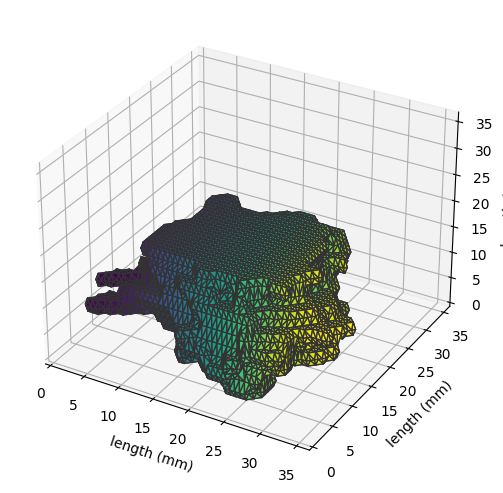

Loading dicom files ... This may take a moment.


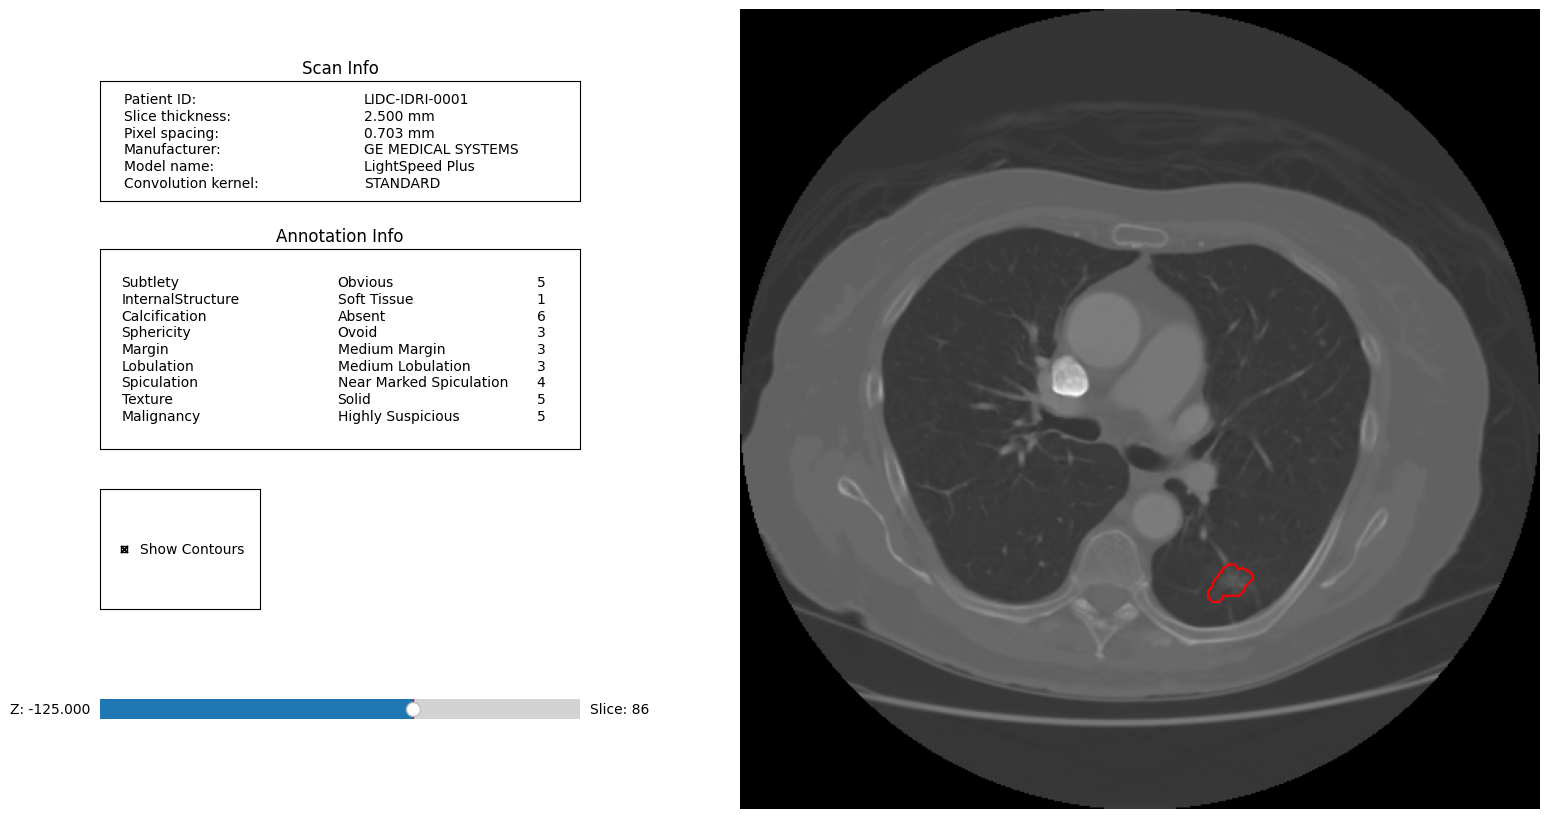

Sphericity: 3.0000
Volume: 7869.37 cubic mm
Surface area: 2801.43 square mm
Average texture score: 5
Calcification: 6


In [3]:
first_annotation = anns[0]
first_annotation.visualize_in_3d()
first_annotation.visualize_in_scan()
# Extract relevant features 
print(f"Sphericity: {first_annotation.sphericity:.4f}")
print(f"Volume: {first_annotation.volume:.2f} cubic mm")
print(f"Surface area: {first_annotation.surface_area:.2f} square mm")
print(f"Average texture score: {first_annotation.texture}")
print(f"Calcification: {first_annotation.calcification}")



This process will be repeated iteratively across the entire dataset to ensure the creation of a comprehensive and reliable dataset. The next step involves analyzing and exploring the patterns and consistency of the annotations provided by the radiologists to better understand their behavior and inter-observer variability.

In [ ]:
from data_viz import plot_all_patients_annotations

plot_all_patients_annotations(plot = False)



![distr](images/anotation_properties.png)

From the graph shown above, we can conclude that the annotations are **not evenly distributed**. If we observe closely, we can see how the surface area, diameter, and volume of the nodules seem to be somewhat related, as all three display a slightly left-skewed graph, especially the diameter.

On the other hand, we can see that the predominant texture of the nodules is solid, but with a soft-tissue internal structure and lacking calcification.

Finally, it is important to note in the Malignancy rating graph that most of the nodule annotations are ambiguous, which often implies that **classifying nodules is not an easy task**, even for professionals in the field.

### **Hounsfield Units(HU)**
Texture plays a crucial role in identifying malignant nodules, as we will further explore below. It can provide significant insight into the internal composition of a nodule, helping differentiate between benign and malignant characteristics. In CT scans, pixel values are represented in Hounsfield Units (HU), which measure the density of tissues. This allows for a more precise analysis of the nodule's texture by distinguishing between soft tissue, calcifications, and other structures based on their specific HU values.
$$HU(x,y) \equiv 1000 \cdot \frac{\mu(x,y) - \mu_{\text{water}}}{\mu_{\text{water}}-\mu_\text{air}}$$

where $\mu$ is the linear attenuation coefficient of the material. The linear attenuation coefficient is defined based on how the intensity of a photon beam decays as it passes a distance $x$ through a material $I=I_0e^{-\mu x}$. Note that $\mu$ depends on the energy of the photon beam, and in a CT scan photons usually have energies $\approx 100$ keV. Here are typical HU values:



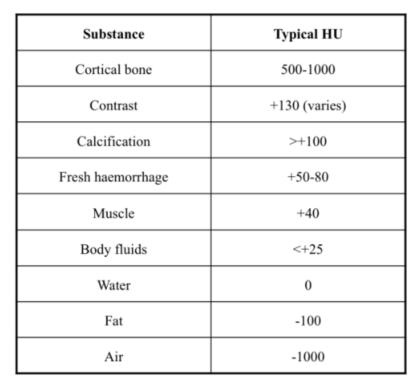

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
# Carga la imagen desde el archivo
imagen = Image.open("images/HU_table.jpg")
plt.imshow(imagen)
plt.axis('off')  # Opcional: Oculta los ejes
plt.show()


For this case, we have arbitrarily set the range of **HU (Hounsfield Unit)** values. Specifically, we are using a range from **-1000 to 400**, as this range appears reasonable based on reference tables. It effectively captures key tissue types such as calcifications, fat, fluids, muscles, and even bones, making it potentially useful for detecting malignant nodules. An image example is shown below:

In [2]:
import pydicom
import numpy as np
# Read DICOM file
from pathlib import Path

from utils import convert_to_HU,clip_hu_range,normalize_hu

# Define the directory of the LIDC-IRDI files. For now we will work with just one random CT slice
directory = Path(r"LIDC-IDRI\LIDC-IDRI-0002\1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160200744295382098329")

# Iterate over the files of this directory 
for idx,archive in enumerate(directory.rglob('*')):

    if archive.is_file() and idx<=1: # Ignorar directorys
        # HU conversion from pixels
        hu_image = convert_to_HU(archive)

        # Cap HU units
        clipped_image = clip_hu_range(hu_image)

        # Normalize
        """
        normalized_image = normalize_hu(clipped_image)
        plt.pcolormesh(normalized_image, cmap='gray')
        plt.title("CT Normalized Image")
        plt.show()
        """
        
        

![images/hu_image_sample.png](images/hu_image_sample12.png)

### **Wavelets**
Wavelets are powerful mathematical tools used in signal processing and image analysis. Unlike traditional Fourier transforms, which break down signals into infinite sinusoidal waves, wavelets allow us to decompose signals into small, localized wave-like components. This makes wavelets particularly well-suited for analyzing non-stationary signals or signals that have transient or abrupt changes, such as medical images where detail, texture, and edges are crucial.

There are several families of wavelets, each with different characteristics. In this case, we will use **Haar**, as they are widely used in medical imaging due to their ability to capture both fine and coarse details efficiently, while maintaining low computational requirements. Besides, they have presented the best results empirically.

Daubechies db4 wavelets are computed by first applying low-pass and high-pass filters to the image to separate low-frequency (approximation) and high-frequency (detail) components. These filtered signals are then downsampled (reducing the data size by half), and the process is repeated for the approximation component at multiple scales to capture different levels of detail. This hierarchical decomposition enables multiresolution analysis, making wavelets ideal for complex image processing tasks.

In [ ]:
import pywt
import cv2
import matplotlib.pyplot as plt

image = cv2.imread('images/lung.png', cv2.IMREAD_GRAYSCALE)
coeffs = pywt.wavedec2(image, 'haar', level=3)

# Extract approximation and detail coefficients 
cA, (cH, cV, cD) = coeffs[0], coeffs[-1]

"""
# Display the approximation and detail components
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.imshow(cA, cmap='gray')
plt.title('Approximation Coefficients')

plt.subplot(1, 4, 2)
plt.imshow(cH, cmap='gray')
plt.title('Horizontal Detail Coefficients')

plt.subplot(1, 4, 3)
plt.imshow(cV, cmap='gray')
plt.title('Vertical Detail Coefficients')

plt.subplot(1, 4, 4)
plt.imshow(cD, cmap='gray')
plt.title('Diagonal Detail Coefficients')

plt.show()
"""

"\n# Display the approximation and detail components\nplt.figure(figsize=(12, 6))\nplt.subplot(1, 4, 1)\nplt.imshow(cA, cmap='gray')\nplt.title('Approximation Coefficients')\n\nplt.subplot(1, 4, 2)\nplt.imshow(cH, cmap='gray')\nplt.title('Horizontal Detail Coefficients')\n\nplt.subplot(1, 4, 3)\nplt.imshow(cV, cmap='gray')\nplt.title('Vertical Detail Coefficients')\n\nplt.subplot(1, 4, 4)\nplt.imshow(cD, cmap='gray')\nplt.title('Diagonal Detail Coefficients')\n\nplt.show()\n\n"

![wave](images/wavelets.png)

Wavelets have a wide range of applications beyond computer vision, including but not limited to feature extraction, segmentation, and noise reduction. They are also employed in fields such as time-series analysis for denoising and in various other applications, including audio processing and data compression. In this particular study, while **wavelets will not be utilized directly in the model** , their implementation could significantly enhance the robustness and performance of trained models. By capturing localized features and managing noise more effectively, wavelet transforms can provide a richer representation of the data, potentially leading to improved classification accuracy and generalization capabilities.

## **Dataset Preparation**
After conducting a thorough analysis of the data, we will proceed with the construction of the dataset, which will serve as the foundation for training machine learning models. Our primary objective is to **predict the benignity of a nodule** based on features annotated by radiologists, as well as characteristics extracted from the images. Examples of features that can be extracted include texture measures, shape descriptors, and statistical metrics such as intensity histograms.

To achieve this, we will utilize statistical summaries of the annotations and the CT slices, primarily focusing on metrics like the mean and mode, which will aid in estimating the location of the nodule and feature extraction. This estimation will be crucial for generating the corresponding mask and for determining its associated features.

### **Mask Extraction**
To extract information from the images, we must first segment the nodules. We will employ the *consensus* function from the *PyLidc* library (based on 50% radiologist agreement) to delineate the nodule boundaries. Subsequently, we will utilize relevant CT slices along with their corresponding nodule masks to extract key characteristics.

In [ ]:
from pathlib import Path  
from utils import  segment_lung,calculate_malignancy
import seaborn as sns
from Mask import process_nodule_images_masks

# Para nombrar cada imagen y máscara
prefix = [str(x).zfill(3) for x in range(1000)]

scan = pl.query(pl.Scan) # Iterate through all patients

for sc in scan : 
    nodules_annotation_list = sc.cluster_annotations()  
    vol = sc.to_volume()  # Convierte el escaneo a un volumen numpy
    print("Patient ID: {} Dicom Shape: {} Number of Annotated Nodules: {}".format(sc.patient_id, vol.shape, len(nodules_annotation_list)))
    
    process_nodule_images_masks(pid=sc.patient_id, 
                            nodules_annotation = nodules_annotation_list, 
                            vol = vol, 
                            consensus_func = consensus, 
                            calculate_malignancy_func = calculate_malignancy,
                            prefix = prefix)





In [ ]:
from data_viz import plot_CT

# Cargar el archivo .npy
file_path = r"data\image\LIDC-IDRI-0110\0110_NI001_slice048.npy" # Reemplaza con la ruta a tu archivo
data = np.load(file_path)

# Cargar el archivo .npy
file_path2 = r"data\mask\LIDC-IDRI-0110\0110_MA001_slice048.npy" # Reemplaza con la ruta a tu archivo
data2 = np.load(file_path2)


# Imprimir la forma del arreglo
print("Forma de los arreglos:", data.shape, data2.shape)

plot_CT(data), plot_CT(data2)


Forma de los arreglos: (512, 512) (512, 512)


![images/mask1.png](images/mask12.png)

### **Feature Extraction**

Once the slices and their masks have been extracted, we will proceed with feature extraction. First, we will apply the Hounsfield Units cap, as mentioned in the exploratory analysis. Next, we will utilize the *RadiomicsFeatureExtractor* from the PyRadiomics package. We will extract features such as **first-order statistics** (e.g., mean, variance, energy), **2D shape-based features** (e.g., surface area, sphericity), and **texture features** (e.g., gray-level co-occurrence matrix (GLCM), gray-level run length matrix (GLRLM)).

In [ ]:
from Mask import load_npy, extract_radiomics
from data_viz import pre_post_HU

# Cargar un archivo .npy del escaneo, y ver la comparativa 
file_path = r"data\image\LIDC-IDRI-0001\0001_NI000_slice093.npy"
data_pre = np.load(file_path)
data = np.clip(data_pre, -1000, 400)
#pre_post_HU(data_pre, data)

# Cargar el archivo .npy de la máscara (booleana)
file_path2 = r"data\mask\LIDC-IDRI-0001\0001_MA000_slice093.npy"
data2 = np.load(file_path2)

# Extraer características radiómicas
f = extract_radiomics(data, data2)

plot_CT(data), plot_CT(data2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


![images/preposthu.png](images/pre_post_hu.png)

#### **2D vs. 3D approach**

To address this problem, two primary avenues could have been pursued: a two-dimensional (2D) approach or a three-dimensional (3D) approach. In this study, we opted for the 2D strategy, thereby placing a greater emphasis on image processing and feature extraction from individual CT slices.

In contrast, a 3D approach could have provided a more comprehensive understanding of nodule characteristics by leveraging volumetric information across multiple slices. This method would capture the spatial relationships and morphological features of nodules in their entirety, potentially leading to improved prediction accuracy. Advanced 3D convolutional neural networks (CNNs) could have been employed to exploit the full three-dimensional context of the nodules, offering a deeper analysis of their complex shapes and textures.

However, while the 3D approach can integrate spatial information across slices, it may introduce additional noise due to the surrounding anatomy and irrelevant structures captured in the volume. In comparison, the **2D approach enables a more targeted analysis, focusing specifically on each slice where the nodule is visible**, thereby reducing potential distractions from extraneous features. This focus on individual slices allows for a streamlined feature extraction that hones in on the areas of interest. Besides, there are some papers that mention getting a higher accuracy with a bidimensional approach.


#### **Radiomics Feature Extractor**


In [ ]:
import os
import numpy as np
from pathlib import Path

# Directorios de imágenes y máscaras
IMAGES_DIR = r"data/image"
MASKS_DIR = r"data/mask"
BASIC_OUTPUT_DIR = r"nodules_csv"

# Inicializar el almacenamiento de datos
data_storer = {}



# Recorre cada paciente en el directorio de imágenes
for paciente in os.listdir(IMAGES_DIR):
    data_storer[paciente] = {}
    paciente_dir = os.path.join(IMAGES_DIR, paciente)
    Nodulo_actual = None  # Variable para trackear el nódulo actual


    # Si el paciente no existe en BASIC_OUTPUT_DIR, crea la carpeta
    output_dir_paciente = os.path.join(BASIC_OUTPUT_DIR, paciente)
    if not os.path.exists(output_dir_paciente):
        os.makedirs(output_dir_paciente)

    # Recorre cada archivo de nódulo en la carpeta del paciente
    for archivo in os.listdir(paciente_dir):
        archivo_path = os.path.join(paciente_dir, archivo)

        # Extraer el nódulo actual de las posiciones 6:10 de la ruta del archivo
        Nodulo = archivo[6:10]  # Asume que el nombre del archivo sigue el formato correcto
        print(f"Nodule: {Nodulo}, Current Nodule: {Nodulo_actual}")

        if Nodulo_actual != Nodulo:
            Nodulo_actual = Nodulo
            data_storer[paciente][Nodulo_actual] = {}

        # Modificar el nombre del archivo para encontrar la máscara correspondiente
        # Ejemplo: data/image/LIDC-IDRI-0003/0003_NI000_slice062.npy -> data/mask/LIDC-IDRI-0003/0003_MA000_slice062.npy
        mascara_path = archivo_path.replace(IMAGES_DIR, MASKS_DIR).replace("_NI", "_MA")

        try:
            # Cargar las imágenes y máscaras
            imagen_original = np.load(archivo_path)
            imagen_hu = np.clip(imagen_original, -1000, 400)  # Aplicar el clip a Hounsfield Units

            mask = np.load(mascara_path)

            # Extraer características radiómicas
            radiomics_features = extract_radiomics(imagen_hu, mask)

            # Almacenar las características en data_storer
            data_storer[paciente][Nodulo_actual][archivo] = radiomics_features

        except FileNotFoundError:
            print(f"File not found: {archivo_path} or {mascara_path}")
        except Exception as e:
            print(f"Error processing file {archivo}: {e}")

# Convertir el diccionario a algo serializable por JSON
#serializable_data = convert_to_serializable(data_storer)


In [58]:
import json
from utils import load_json,dump_json,convert_to_serializable

data_storer = load_json("output_data.json")



In [8]:
import numpy as np
import pandas as pd
from utils import get_features_list
from collections import defaultdict

# Cargar el JSON
data_storer = load_json("output_data.json")

# Obtener la lista de features que empiezan con 'original'
feature_list = get_features_list(data_storer)

# Crear un DataFrame vacío con columnas para el paciente, nódulo y las características
df = pd.DataFrame(columns=['Patient', 'Nodule'] + feature_list)

# Recorrer cada paciente y nódulo en el JSON
for paciente, nodulos in data_storer.items():
    
    # Recorre cada nódulo del paciente
    for nodulo, cts in nodulos.items():
        
        # Diccionario para almacenar listas de valores por característica
        feature_values = defaultdict(list)
        
        # Recorre cada CT dentro del nódulo
        for ct, caracteristicas in cts.items():
            
            # Recorre las características de cada CT
            for key, value in caracteristicas.items():
                if key.startswith("original") and isinstance(value, (int, float)):
                    feature_values[key].append(value)  # Añade el valor a la lista correspondiente en feature_values

        # Calcular la media de cada característica para el nódulo
        row_data = {'Patient': paciente, 'Nodule': nodulo}
        for feature in feature_list:
            if feature in feature_values:
                row_data[feature] = np.mean(feature_values[feature])  # Media de los valores
            else:
                row_data[feature] = np.nan  # Si no hay datos para esta característica

        # Añadir los resultados al DataFrame
        df = df._append(row_data, ignore_index=True)

# Guardar el DataFrame a un archivo CSV
output_csv_path = 'output_media_nodulos.csv'
df.to_csv(output_csv_path, index=False)

print(f"CSV saved to {output_csv_path}")


CSV saved to output_media_nodulos.csv


#### **Annotations**

To simplify the classification process, we extract malignancy annotations from a set of patient scans, organizing them into a DataFrame for streamlined classification. We then calculate the mean and mode of the annotation values, storing this information for easy processing in future analysis.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylidc as pl 
from utils import classify_nodule
scan = pl.query(pl.Scan) # Iterate through all patients
# Asumiendo que scan ya está definido y contiene tus datos
data = []

for sc in scan: 
    nodules_annotation_list = sc.cluster_annotations() 
    for idx, nodule in enumerate(nodules_annotation_list): 
        lista_annotations = [anotation.malignancy for anotation in nodule]
        data.append((sc.patient_id, "I00"+ str(idx), lista_annotations))

# Crear un DataFrame a partir de los datos
df = pd.DataFrame(data, columns=['patient_id', 'nodule_index', 'annotations'])
# Añadimos dos nuevas columnas: una para la longitud de las listas y otra para su suma
df['length'] = df['annotations'].apply(len)


# Ahora ordenamos primero por longitud (descendente) y luego por la suma (también descendente)
l_sorted = df.sort_values(by=['length'], ascending=[True])

l_sorted['m'] = l_sorted.apply(
    lambda row: classify_nodule(row['annotations'],lower_limit=2),
    axis=1
)
def get_first(tuple):
    return tuple[0]

l_sorted['Malignancy_al'] = l_sorted['m'].apply(get_first)
l_sorted.to_csv("files/malignancies2.csv",index=None)


In [1]:
from Nodule import AverageNodule
import pandas as pd
from utils import search_malignancy
import pylidc as pl

# Crear un nuevo DataFrame para almacenar los datos calculados
columns = ['Patient', 'Nodule', 'Sphericity', 'Volume', 'Surface_area', 'Texture', 
           'Calcification', 'Internal_structure', 'Margin', 'Spiculation', 'Subtlety', 'Diameter', 'Lobulation','Malignancy_al']

data = pd.DataFrame(columns=columns)
malig = pd.read_csv('files/malignancies.csv')
# Iterar a través de todos los scans
scan = pl.query(pl.Scan)  

for sc in scan:
    nodules_annotation_list = sc.cluster_annotations()  # Obtener la lista de nódulos
    for idx, nodule in enumerate(nodules_annotation_list):
        # Crear una instancia de AverageNodule
        AvgN = AverageNodule(idx, nodule, sc.patient_id)
        
        # Obtener el resumen de la información del nódulo
        resume = AvgN.get_annot_info()

        # Crear una nueva fila con los datos
        row_data = {
            'Patient': sc.patient_id,
            'Nodule': "I00" + str(idx),  
            'Sphericity': resume.get('mode_sphericity', None),
            'Volume': resume.get('mean_volume', None),
            'Surface_area': resume.get('mean_surface_area', None),
            'Texture': resume.get('mode_texture', None),
            'Calcification': resume.get('mode_calcification', None),
            'Internal_structure': resume.get('mode_internal_structure', None),
            'Margin': resume.get('mode_margin', None),
            'Spiculation': resume.get('mode_spiculation', None),
            'Subtlety': resume.get('mode_subtlety', None),
            'Diameter': resume.get('mean_diameter', None),
            'Lobulation': resume.get('mode_lobulation', None),
            'Malignancy_al': search_malignancy(malig,sc.patient_id,"I00" + str(idx)),
        }
        #print(row_data)
        # Añadir la fila al DataFrame 'data'
        data = data._append(row_data, ignore_index=True)

# Ordenar el DataFrame por 'Patient' y 'Nodule'
data = data.sort_values(by=['Patient', 'Nodule'])
# Guardar el nuevo DataFrame a un CSV
output_csv_path = 'files/output_media_annotations_al2.csv'
data.to_csv(output_csv_path, index=False)

print(f"CSV saved to {output_csv_path}")


Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some n

In [2]:
import pandas as pd 

df_extractor = pd.read_csv("files/output_media_nodulos.csv")
df_annotations = pd.read_csv("files/output_media_annotations_al2.csv")

df_merged = pd.merge(df_extractor, df_annotations, how='inner', on=['Patient', 'Nodule'])

## **Model Development**
Following the analysis of the data, extraction of CT slice masks for the nodules, and the subsequent *feature engineering*, we finalized the construction of the dataset. Specifically, we obtained a total of **2,575 rows**, corresponding to the intersection of the image dataset and nodules across different patients from the `LIDC-IDRI` database. The next step involves the development, evaluation, and hyperparameter tuning of various statistical machine learning models, aimed at predicting the malignancy of the nodules based on the extracted features.

### **Ambigous nodule malignancy annotations : Semi-Supervised Learning Approach**

Upon analyzing the malignancy annotations provided by radiologists (ranging from 1 to 5, with 1 being benign and 5 being malignant), we observe a non-uniform distribution of the data. Notably, around 40% of the labeled data fall into inconclusive categories, complicating the binary classification process. Given this ambiguity, we adopt a **semi-supervised learning approach** to increase both the size and robustness of our training dataset.

Specifically, we leverage **inductive** and **transductive** techniques to utilize both labeled and *"unlabeled"* data. This approach allows us to propagate label information from high-confidence samples to uncertain ones, enhancing the model’s ability to generalize while improving reliability and robustness in predicting nodule malignancy.


![distribution_nodulo_malignancy](images/distribution_nodulo_malignancy.png)


#### **Label Co-ocurrency Matrix**

The co-occurrence matrix is a general analytical tool used in various fields, mainly graph theory, to represent the relationships between different elements. It provides a visual and quantitative method for examining how often pairs of items appear together.

In the context of the LIDC-IDRI (Lung Image Database Consortium and Image Database Resource Initiative) dataset, the co-occurrence matrix is employed to study the relationships between annotations made by radiologists. Specifically, it allows us to analyze the degree to which radiologists agree or disagree on their assessments, such as when one radiologist marks a finding as "unlikely" and how often another radiologist does the same. By examining these co-occurrences, we can gain insights into the consistency and variability of radiological interpretations.

This analysis is particularly relevant for validating the three main assumptions of semi-supervised learning:

1. **Smoothness Assumption**: If two objects $x_i$ and $x_j$ are similar, their class labels should be the same, represented as $y_i$ = $y_j$. By examining the co-occurrence of annotations, we can see that the diagonal values represent the agreement between radiologists within the same category.Radiologists tend to classify similar findings similarly, implying that objects within the same class tend to have consistent labels.

2. **Low-Density Assumption**: The decision boundaries of the model should pass through areas of low density. Analyzing the co-occurrence of annotations helps identify regions in the feature space where radiologists agree or disagree, providing insight into the boundaries of decision-making and ensuring that the model does not overly focus on high-density areas that could lead to overfitting. In this case, despite high diagonal values indicating strong agreement within classes, we can see how in certain regions, the density is not as low as desired near the decision boundaries. Therefore, density-based algorithms might struggle in this database misclassifying instances in regions of overlap or uncertainty.

3. **Manifold Assumption**: If two objects $x_i$ and $x_j$ lie within the same manifold, their class labels should also be the same, represented as $y_i$ = $y_j$. The co-occurrence matrix helps us visualize that different annotations correspond to similar underlying structures or characteristics in the data, reinforcing the idea that similar cases are likely to have the same label.


![co-ocurrency](images/co_ocurrency_malignancies_matrix.png)

#### **Label Algorithm**

Since this problem involves uncertain data, based on expert opinions and subjective assessments, our approach aims to maximize consensus while minimizing risk. To achieve this, we developed an algorithm that requires two mandatory input parameters: the list of nodule malignancy annotations and a standard deviation threshold (while computing $\sigma$, non-certain annotations are not taken into account ). Additionally, there are three optional parameters: the lower and upper limits, representing the minimum and maximum list lengths considered for labeling, and the final parameter is the allowed occurrence of "3"s within the array for it to be deemed eligible for labeling.

![frecuency_malig_len](images/frecuency_malignancy_annotations.png)

Taking into account the array lenght distribution shown above, the algorithm follows these core rules:

- **Benign Classification:** A nodule is classified as benign if the number "3" appears at most the occurrence of "3"s(by default 1) within the malignancy annotations. In addition, any other repeated values must be restricted to either "1" or "2." Furthermore, a nodule can also be labeled as benign if no "3"s are present, and the repeated values consist solely of "1"s or "2"s.

- **Malignant Classification:** A nodule is classified as malignant if the number "3" appears at most the occurrence of "3"s(by default 1). In this case, the remaining repeated values must be limited to either "4" or "5." A nodule can also be classified as malignant if there is no occurrence of "3," and the repeated values consist only of "4"s or "5"s.

- **Unlabeled Classification:** A nodule remains unlabeled if the number "3" appears more than the occurrence of "3"s. Additionally, the nodule cannot be classified as benign or malignant if the lower and upper array length conditions are not upheld, or if the criteria for either classification are not met (e.g., a mixture of values such as "1," "2," "4," and "5," or any other inconsistent pattern greater than $\sigma$ threshold).

In [3]:
df_merged.to_csv("files/df_merged.csv")

#### **Label Propagation vs. Label Spreading**

Semi-supervised learning is a branch of machine learning that combines supervised and unsupervised learning by using **both labeled and unlabeled** data to train artificial intelligence (AI) models for classification and regression tasks.

Semi-supervised learning methods are especially relevant in situations where obtaining a sufficient amount of labeled data is prohibitively difficult or expensive, but large amounts of unlabeled data are relatively easy to acquire.


- `Label propagation` is a graph-based semi-supervised learning algorithm that determines label assignments for unlabeled data by leveraging their proximity to labeled instances. This method relies on two core assumptions: the **smoothness assumption**, which suggests that points close in the feature space are likely to share the same label, and the **cluster assumption**, which posits that data points form distinct clusters with consistent labels.

The algorithm operates by constructing a fully connected graph, where nodes represent both labeled and unlabeled data points. The edges between nodes are weighted based on a predefined distance metric, such as Euclidean distance, with closer nodes having stronger connections. Starting with the labeled nodes, the labels are iteratively propagated to their neighboring unlabeled nodes, guided by the smoothness and cluster assumptions, until label convergence is achieved.

- `Label spreading` is an extension of label propagation that improves the label diffusion process using two key modifications. First, it constructs an affinity matrix based on the normalized graph Laplacian, which ensures a smoother and more balanced spread of labels by normalizing the graph's structure and controlling for variations in node connectivity. Second, it applies soft clamping to the labeled points, allowing their labels to slightly adjust during the propagation process, rather than keeping them fixed. This leads to a more flexible and stable label assignment for both labeled and unlabeled data.

![labelprop](images/label_prop.png)



In [8]:
import pandas as pd
import ast

# Cargar el archivo CSV
data = pd.read_csv("files/df_merged.csv")

# Función para obtener el primer valor de la lista o manejar los valores "UnlabeledUnlabeled"
def get_0(l):
    if isinstance(l, str) and "UnlabeledUnlabeled" in l:
        return "Unlabeled"
    elif isinstance(l, list):
        return l[0]
    else:
        return l

# Convertir cadenas que parecen listas a listas reales y aplicar get_0
data['Malignancy_al'] = data['Malignancy_al'].apply(lambda x: get_0(ast.literal_eval(x)) if isinstance(x, str) else get_0(x))
data['Malignancy_al'] = data['Malignancy_al'].replace('UnlabeledUnlabeled', 'Unlabeled') ## Very few cases of error of the algorith
data['Malignancy_al'] = data['Malignancy_al'].replace('MalignoUnlabeled', 'Unlabeled')
data['Malignancy_al'] = data['Malignancy_al'].replace('BenignoUnlabeled', 'Unlabeled')

data = data.drop_duplicates(subset=['Patient', 'Nodule'])
# Muestra las primeras filas del DataFrame
print(data.head())
data.to_csv("files/final.csv")
data['Malignancy_al'].value_counts()

   Unnamed: 0         Patient Nodule  original_firstorder_10Percentile  \
0           0  LIDC-IDRI-0001   I000                       -392.712500   
1           1  LIDC-IDRI-0002   I000                       -798.528571   
2           2  LIDC-IDRI-0003   I000                       -796.625000   
3           3  LIDC-IDRI-0003   I001                       -513.500000   
4           4  LIDC-IDRI-0003   I002                       -606.900000   

   original_firstorder_90Percentile  original_firstorder_Energy  \
0                         50.100000                3.813613e+07   
1                       -568.957143                2.612477e+08   
2                       -505.437500                1.369430e+08   
3                         24.828571                3.709152e+07   
4                       -251.675000                1.196120e+07   

   original_firstorder_Entropy  original_firstorder_InterquartileRange  \
0                     4.334461                              226.750000   
1   

Malignancy_al
Unlabeled    1956
Benigno       386
Maligno       212
Name: count, dtype: int64

(598, 105) (598,)
Unique labels in y_labeled before mapping: ['Maligno' 'Benigno']
Unique labels in y_labeled after mapping: [1 0]
Count of NaN values in y_labeled: 0
Shape of X: (2434, 105)
Shape of y: (2434,)


C:\Users\Alejandro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Accuracy on hold-out set (Label Propagation): 0.9
Precision (Label Propagation): 0.8780487804878049
Recall (Label Propagation): 0.8372093023255814
F1 Score (Label Propagation): 0.8571428571428572
Predicted labels (Label Propagation) for ambiguous data: [0 0 1 ... 0 1 0]


C:\Users\Alejandro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Accuracy on hold-out set (Label Spreading): 0.925
Precision (Label Spreading): 0.9473684210526315
Recall (Label Spreading): 0.8372093023255814
F1 Score (Label Spreading): 0.8888888888888888
Predicted labels (Label Spreading) for ambiguous data: [0 0 1 ... 0 1 0]


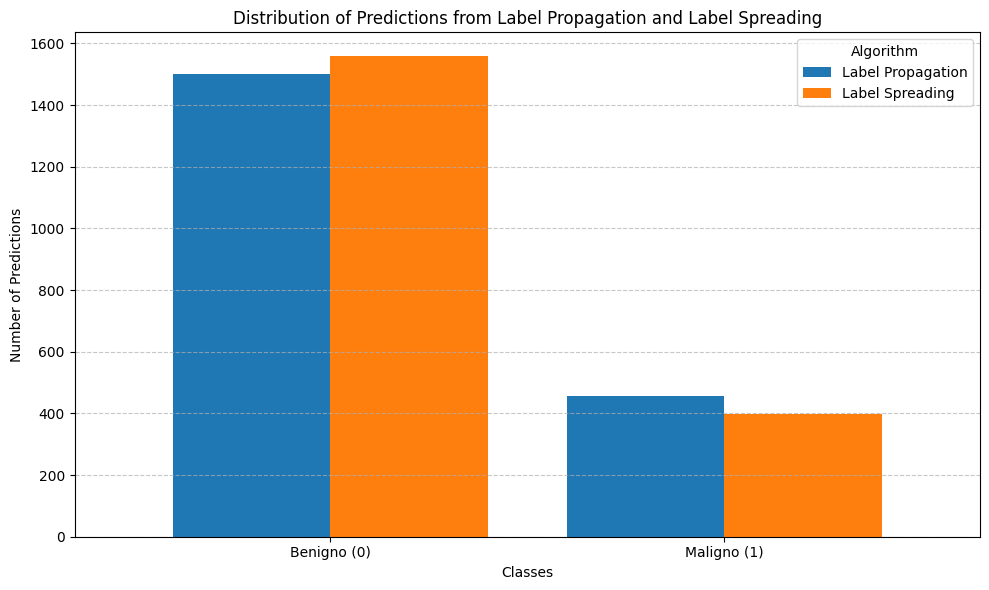

In [9]:
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Filtramos los datos no ambiguos (Malignancy != "Unlabeled")
X_labeled = data[data["Malignancy_al"] != "Unlabeled"].drop(columns=["Malignancy_al", "Patient", "Nodule"])
y_labeled = data[data["Malignancy_al"] != "Unlabeled"]["Malignancy_al"]

# Filtramos los datos ambiguos (Malignancy == "Unlabeled")
X_ambiguous = data[data["Malignancy_al"] == "Unlabeled"].drop(columns=["Malignancy_al", "Patient", "Nodule"])
y_ambiguous = data[data["Malignancy_al"] == "Unlabeled"]["Malignancy_al"]

# Imprimimos las dimensiones de los conjuntos de datos
print(X_labeled.shape, y_labeled.shape)

# Check unique values in the original labels
print("Unique labels in y_labeled before mapping:", y_labeled.unique())

################### DATA TREATMENT ########################
scaler = StandardScaler()

# Define label mapping based on unique values in y_labeled
label_mapping = {
    "Benigno": 0,
    "Maligno": 1,
    "Unlabeled": -1  # If you want to treat "Unlabeled" specifically
}

# Map labels to integers
y_labeled = y_labeled.map(label_mapping)

# Check for NaN values and unique labels
print("Unique labels in y_labeled after mapping:", y_labeled.unique())
print("Count of NaN values in y_labeled:", y_labeled.isna().sum())

# Split labeled data into training and hold-out (validation) sets
X_train, X_val, y_train, y_val = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42, stratify=y_labeled)

# Normalize features
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_ambiguous_scaled = scaler.transform(X_ambiguous)

# Combine training and ambiguous data into a single feature matrix
X = np.vstack([X_train_scaled, X_ambiguous_scaled])
y = np.hstack([y_train, [-1] * len(y_ambiguous)])

# Imprimimos las dimensiones de X y y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

################### LABEL PROPAGATION ########################
# Definimos el modelo de Label Propagation
label_prop_model = LabelPropagation()

# Entrenamos el modelo con los datos
label_prop_model.fit(X, y)

# Predecimos las etiquetas para el conjunto de validación
y_val_pred_prop = label_prop_model.predict(X_val_scaled)
accuracy_prop = accuracy_score(y_val, y_val_pred_prop)
precision_prop = precision_score(y_val, y_val_pred_prop, pos_label=1, zero_division=0)
recall_prop = recall_score(y_val, y_val_pred_prop, pos_label=1, zero_division=0)
f1_prop = f1_score(y_val, y_val_pred_prop, pos_label=1, zero_division=0)

print("Accuracy on hold-out set (Label Propagation):", accuracy_prop)
print("Precision (Label Propagation):", precision_prop)
print("Recall (Label Propagation):", recall_prop)
print("F1 Score (Label Propagation):", f1_prop)

# Predecimos las etiquetas para los datos ambiguos
y_pred_ambiguous_prop = label_prop_model.transduction_[-len(y_ambiguous):]
print("Predicted labels (Label Propagation) for ambiguous data:", y_pred_ambiguous_prop)

################### LABEL SPREADING ########################
# Definimos y entrenamos el modelo de Label Spreading
label_spread_model = LabelSpreading()
label_spread_model.fit(X, y)

# Predecimos las etiquetas para el conjunto de validación
y_val_pred_spread = label_spread_model.predict(X_val_scaled)
accuracy_spread = accuracy_score(y_val, y_val_pred_spread)
precision_spread = precision_score(y_val, y_val_pred_spread, pos_label=1, zero_division=0)
recall_spread = recall_score(y_val, y_val_pred_spread, pos_label=1, zero_division=0)
f1_spread = f1_score(y_val, y_val_pred_spread, pos_label=1, zero_division=0)

print("Accuracy on hold-out set (Label Spreading):", accuracy_spread)
print("Precision (Label Spreading):", precision_spread)
print("Recall (Label Spreading):", recall_spread)
print("F1 Score (Label Spreading):", f1_spread)

# Predecimos las etiquetas para los datos ambiguos
y_pred_ambiguous_spread = label_spread_model.transduction_[-len(y_ambiguous):]
print("Predicted labels (Label Spreading) for ambiguous data:", y_pred_ambiguous_spread)

################### PLOTTING ########################
# Count the predictions for each model
counts_prop = pd.Series(y_pred_ambiguous_prop).value_counts()
counts_spread = pd.Series(y_pred_ambiguous_spread).value_counts()

# Prepare data for plotting
labels = ['Benigno (0)', 'Maligno (1)']
count_data = {
    'Label Propagation': [counts_prop.get(0, 0), counts_prop.get(1, 0)],
    'Label Spreading': [counts_spread.get(0, 0), counts_spread.get(1, 0)],
}

# Create DataFrame
counts_df = pd.DataFrame(count_data, index=labels)

# Plotting
ax = counts_df.plot(kind='bar', figsize=(10, 6), width=0.8)

# Customizing the plot
plt.title('Distribution of Predictions from Label Propagation and Label Spreading')
plt.xlabel('Classes')
plt.ylabel('Number of Predictions')
plt.xticks(rotation=0)
plt.legend(title='Algorithm')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# 1. Usar las etiquetas de Label Propagation
# Para entrenar el modelo, combinamos los datos etiquetados originales con las etiquetas predichas para los datos ambiguos
y_combined_prop = np.hstack([y_train, y_pred_ambiguous_prop])
X_combined_prop = np.vstack([X_train_scaled, X_ambiguous_scaled])
# Entrenar un modelo de regresión logística con las etiquetas de Label Propagation
log_reg_prop = LogisticRegression(max_iter=1000, random_state=42)
log_reg_prop.fit(X_combined_prop, y_combined_prop)

# Evaluar el modelo en el conjunto de validación (esto es la ground truth)
y_val_pred_log_reg_prop = log_reg_prop.predict(X_val_scaled)

# Calcular métricas
accuracy_log_reg_prop = accuracy_score(y_val, y_val_pred_log_reg_prop)
precision_log_reg_prop = precision_score(y_val, y_val_pred_log_reg_prop, average='weighted', zero_division=0)
recall_log_reg_prop = recall_score(y_val, y_val_pred_log_reg_prop, average='weighted', zero_division=0)
f1_log_reg_prop = f1_score(y_val, y_val_pred_log_reg_prop, average='weighted', zero_division=0)
confusion_log_reg_prop = confusion_matrix(y_val, y_val_pred_log_reg_prop)

print("Metrics for Logistic Regression with Label Propagation labels on validation set:")
print(f"Accuracy: {accuracy_log_reg_prop:.4f}")
print(f"Precision: {precision_log_reg_prop:.4f}")
print(f"Recall: {recall_log_reg_prop:.4f}")
print(f"F1 Score: {f1_log_reg_prop:.4f}")
print("Confusion Matrix:\n", confusion_log_reg_prop)


# 2. Usar las etiquetas de Label Spreading
# Para entrenar el modelo, combinamos los datos etiquetados originales con las etiquetas predichas para los datos ambiguos
y_combined_spread = np.hstack([y_train, y_pred_ambiguous_spread])
X_combined_spread = np.vstack([X_train_scaled, X_ambiguous_scaled])

# Entrenar un modelo de regresión logística con las etiquetas de Label Spreading
log_reg_spread = LogisticRegression(max_iter=1000, random_state=42)
log_reg_spread.fit(X_combined_spread, y_combined_spread)

# Evaluar el modelo en el conjunto de validación
y_val_pred_log_reg_spread = log_reg_spread.predict(X_val_scaled)

# Calcular métricas
accuracy_log_reg_spread = accuracy_score(y_val, y_val_pred_log_reg_spread)
precision_log_reg_spread = precision_score(y_val, y_val_pred_log_reg_spread, average='weighted', zero_division=0)
recall_log_reg_spread = recall_score(y_val, y_val_pred_log_reg_spread, average='weighted', zero_division=0)
f1_log_reg_spread = f1_score(y_val, y_val_pred_log_reg_spread, average='weighted', zero_division=0)
confusion_log_reg_spread = confusion_matrix(y_val, y_val_pred_log_reg_spread)

print("\nMetrics for Logistic Regression with Label Spreading labels on validation set:")
print(f"Accuracy: {accuracy_log_reg_spread:.4f}")
print(f"Precision: {precision_log_reg_spread:.4f}")
print(f"Recall: {recall_log_reg_spread:.4f}")
print(f"F1 Score: {f1_log_reg_spread:.4f}")
print("Confusion Matrix:\n", confusion_log_reg_spread)


# Comparación con el modelo de regresión logística entrenado solo con los datos originales
log_reg_original = LogisticRegression(max_iter=1000, random_state=42)
log_reg_original.fit(X_train_scaled, y_train)

# Evaluar el modelo en el conjunto de validación
y_val_pred_log_reg_original = log_reg_original.predict(X_val_scaled)

# Calcular métricas
accuracy_log_reg_original = accuracy_score(y_val, y_val_pred_log_reg_original)
precision_log_reg_original = precision_score(y_val, y_val_pred_log_reg_original, average='weighted', zero_division=0)
recall_log_reg_original = recall_score(y_val, y_val_pred_log_reg_original, average='weighted', zero_division=0)
f1_log_reg_original = f1_score(y_val, y_val_pred_log_reg_original, average='weighted', zero_division=0)
confusion_log_reg_original = confusion_matrix(y_val, y_val_pred_log_reg_original)

print("\nMetrics for Logistic Regression with original labeled data on validation set:")
print(f"Accuracy: {accuracy_log_reg_original:.4f}")
print(f"Precision: {precision_log_reg_original:.4f}")
print(f"Recall: {recall_log_reg_original:.4f}")
print(f"F1 Score: {f1_log_reg_original:.4f}")
print("Confusion Matrix:\n", confusion_log_reg_original)


Metrics for Logistic Regression with Label Propagation labels on validation set:
Accuracy: 0.9417
Precision: 0.9420
Recall: 0.9417
F1 Score: 0.9412
Confusion Matrix:
 [[75  2]
 [ 5 38]]

Metrics for Logistic Regression with Label Spreading labels on validation set:
Accuracy: 0.9500
Precision: 0.9512
Recall: 0.9500
F1 Score: 0.9494
Confusion Matrix:
 [[76  1]
 [ 5 38]]

Metrics for Logistic Regression with original labeled data on validation set:
Accuracy: 0.9417
Precision: 0.9421
Recall: 0.9417
F1 Score: 0.9418
Confusion Matrix:
 [[73  4]
 [ 3 40]]


### **Clustering**


The analysis of the LIDC-IDRI dataset using semi-supervised learning methods, specifically **label spreading** and **label propagation**, showed promising results. However, we shifted our focus to clustering algorithms to gain a deeper understanding of the inherent structure of the dataset and to explore new approaches.

The clustering techniques employed included:

- **Gaussian Mixture Models (GMM)**
- **K-Means**
- **Partitioning Around Medoids (PAM)**
- **Agglomerative Clustering**
- **Spectral Clustering**
- **Birch Clustering**

Particular emphasis was placed on **K-Means**, **PAM**, and **GMM** due to their effectiveness in handling multidimensional data with varied complexity.

#### **Clustering Overview**
Clustering, an unsupervised learning technique aims to organize data into subgroups, or clusters, characterized by shared attributes. This technique is instrumental in revealing latent structures and patterns within the data, facilitating deeper analysis and interpretative insights.

#### **Initial Approach**
Initially, we applied Machine Learning algorithms without hyperparameter optimization to provide a baseline for performance comparison. This approach will enable us the subsequent comparative analysis  of the perfomance of the models with the introduction of the unlabeled data.




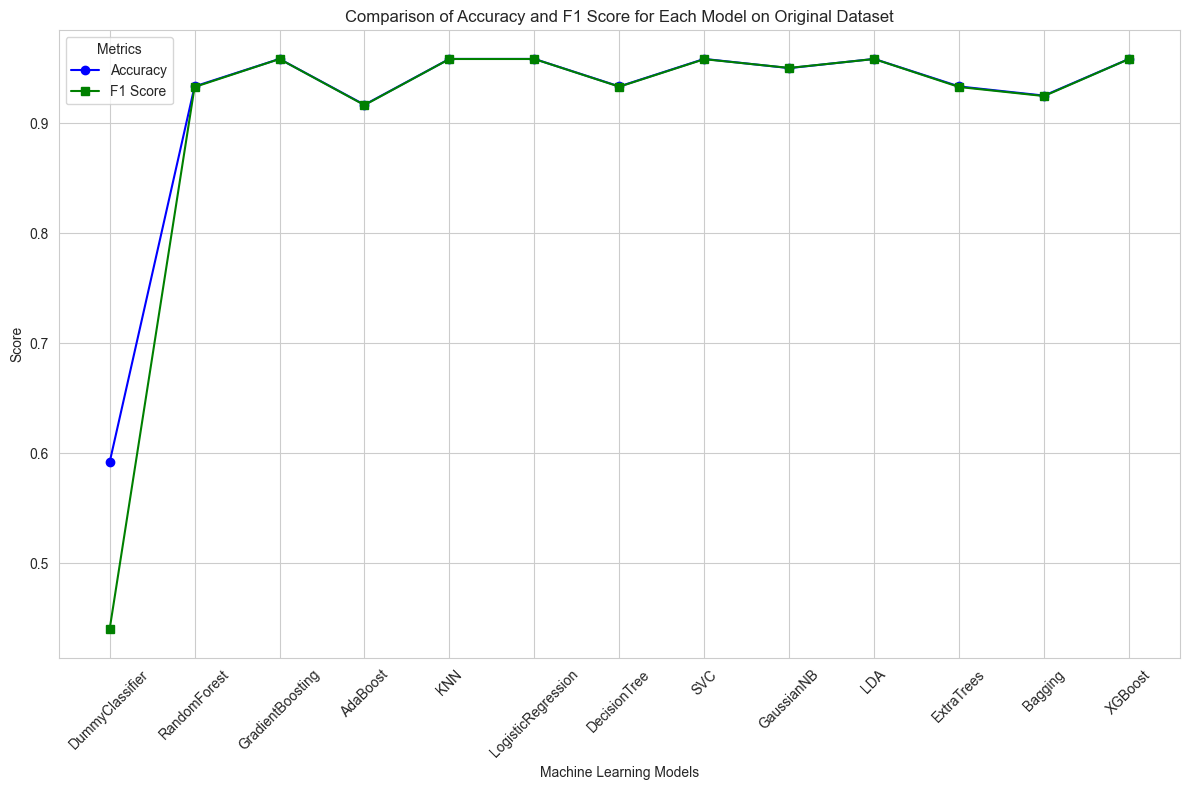

In [13]:
from utils import treat_final_df, create_train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.svm import SVC
import os

# Directory for saving images
directory = "images"
os.makedirs(directory, exist_ok=True)
methods = ['GMM', 'KMeans', 'Spectral', 'Agglomerative', 'Birch','PAM']



# Load data
df = treat_final_df()

# Define models
models = {
    'DummyClassifier': DummyClassifier(),
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'KNN': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(),
    'DecisionTree': DecisionTreeClassifier(),
    'SVC': SVC(),
    'GaussianNB': GaussianNB(),
    'LDA': LinearDiscriminantAnalysis(),
    'ExtraTrees': ExtraTreesClassifier(),
    'Bagging': BaggingClassifier(),
    'XGBoost': XGBClassifier()
}

# Metrics to evaluate
metrics = ['Accuracy', 'F1']

# Prepare data
X = df[df['Malignancy'] != 3].drop(columns=["Malignancy"])
y = df[df['Malignancy'] != 3]["Malignancy"]

# Split data into training and test sets
X_train_scaled, X_test_scaled, y_train, y_test = create_train_test_split(pd.concat([X, y], axis=1), target_column='Malignancy')

# DataFrame to store metric results for each model
metrics_df_original = pd.DataFrame(columns=metrics, index=models.keys())
all_metrics_df_original = {metric: pd.DataFrame(columns=models.keys()) for metric in metrics}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use average='weighted' for multiclass

    # Store the results in the DataFrame
    metrics_df_original.loc[name] = [accuracy, f1]

# Append results to the overall DataFrame
for metric in metrics:
    all_metrics_df_original[metric]['Original'] = metrics_df_original[metric]

# Plot the combined results for Accuracy, F1 Score, and Sensitivity on the same graph
plt.figure(figsize=(12, 8))

# Plot Accuracy
plt.plot(metrics_df_original.index, metrics_df_original['Accuracy'], marker='o', label='Accuracy', color='blue')

# Plot F1 Score
plt.plot(metrics_df_original.index, metrics_df_original['F1'], marker='s', label='F1 Score', color='green')


# Add labels and title
plt.xlabel('Machine Learning Models')
plt.ylabel('Score')
plt.title('Comparison of Accuracy and F1 Score for Each Model on Original Dataset')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.tight_layout()

# Save the combined plot
plt.savefig(os.path.join(directory, 'original_accuracy_f1_sensitivity_comparison_models.png'))
plt.show()


Cross-Validation Results:
Accuracy: 0.93
Precision: 0.93
Recall: 0.93
F1 Score: 0.93
ROC-AUC: 0.97

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95        77
           1       0.97      0.84      0.90        43

    accuracy                           0.93       120
   macro avg       0.94      0.91      0.93       120
weighted avg       0.94      0.93      0.93       120



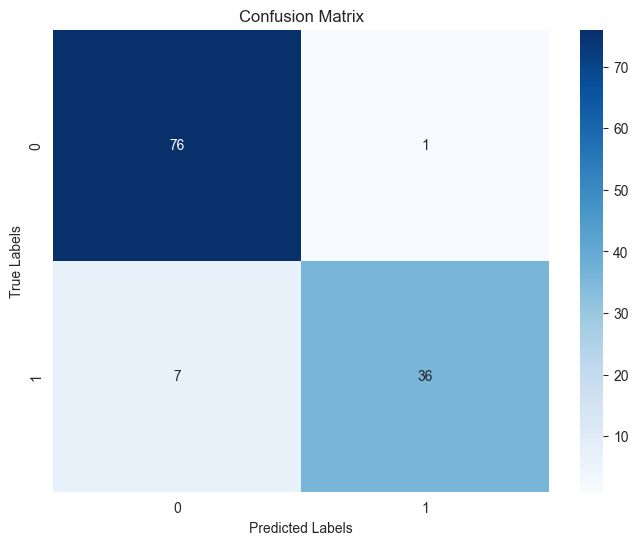

In [14]:

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# Directory for saving images
directory = "images"
os.makedirs(directory, exist_ok=True)

# Load data
df = treat_final_df()

# Prepare data (excluding unlabeled class if exists)
X = df[df['Malignancy'] != 3].drop(columns=["Malignancy"])
y = df[df['Malignancy'] != 3]["Malignancy"]
model = LogisticRegression(max_iter=1000, random_state=42)

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted'),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True, average='weighted', multi_class='ovr')  # Use 'ovr' for multiclass
}

# Perform cross-validation and collect metrics
cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)

# Display average scores
print("Cross-Validation Results:")
print(f"Accuracy: {np.mean(cv_results['test_accuracy']):.2f}")
print(f"Precision: {np.mean(cv_results['test_precision']):.2f}")
print(f"Recall: {np.mean(cv_results['test_recall']):.2f}")
print(f"F1 Score: {np.mean(cv_results['test_f1']):.2f}")
print(f"ROC-AUC: {np.mean(cv_results['test_roc_auc']):.2f}")

# Fit model on the full dataset and plot confusion matrix on a test split
from sklearn.model_selection import train_test_split

# Split for final evaluation on a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Fit the model and predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Print classification report for final evaluation
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


The baseline machine learning model that demonstrated the best performance was **Logistic Regression**, achieving an accuracy of 94%. However, it is crucial to focus on the recall metric, as it is particularly important to minimize false negatives—misclassifying a cancer patient as "healthy" could have serious consequences. Thus, it is preferable for the model to adopt a more conservative approach. To address this, we will employ semi-supervised data to expand the dataset, with the aim of improving recall and overall performance. This approach may enable us to achieve better diagnostic outcomes by leveraging additional, unlabeled data.

#### **Clustering Algorithms**

In this project, we will evaluate various clustering algorithms to compare their performance on unseen data and their ability to generalize for data augmentation. The algorithms are briefly described below:

**K-Means** is an iterative algorithm that assigns each data point to the nearest centroid, recalculating these centroids until cluster memberships stabilize. While it efficiently handles large datasets, K-Means assumes that clusters are spherical and is sensitive to outliers, which can distort the centroid calculations.

In contrast, **Partitioning Around Medoids (PAM)** selects actual data points, known as medoids, as cluster centers. By minimizing the sum of dissimilarities between points and their nearest medoid, PAM demonstrates greater robustness to outliers and noise. However, it is computationally heavier than K-Means due to its reliance on pairwise dissimilarity calculations.

**Gaussian Mixture Models (GMM)** frame clustering as a probabilistic task, modeling the data as a mixture of several Gaussian distributions. Each cluster is represented by a Gaussian distribution characterized by parameters optimized using the Expectation-Maximization (EM) method. GMM is particularly effective for datasets with overlapping clusters or non-spherical shapes, offering a flexibility that distance-based algorithms like K-Means do not provide.

**Agglomerative Clustering** operates on a hierarchical basis, with each data point initially treated as an individual cluster. The algorithm merges clusters step-by-step based on similarity metrics, resulting in a tree structure called a dendrogram. Its versatility is a notable advantage, as it does not assume a specific shape for clusters; however, it can be computationally intensive for larger datasets.

**Spectral Clustering** employs principles from graph theory and spectral analysis. The data is represented as a similarity graph, where nodes correspond to data points and edges represent pairwise similarities. The eigenvalues and eigenvectors of the Laplacian matrix derived from this graph facilitate projecting the data into a lower-dimensional space for easier partitioning. This method excels in identifying complex, non-convex clusters that traditional techniques may struggle to capture, though the computation of eigenvalues for large matrices can be demanding.

Finally, **BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies)** is designed for efficiency in handling large datasets through a tree-like structure known as a Clustering Feature (CF) tree. It clusters data incrementally and adaptively, summarizing points as they are added, thereby reducing computational load and memory usage.





#### **Clustering Metrics**


**Silhouette Score**

The Silhouette Score is a measure that quantifies how well data points align with their designated clusters compared to the nearest alternative cluster. It is mathematically expressed as:

$$s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}$$

Where:

- **$a(i)$** represents the average intra-cluster distance (the mean distance between a point and all other points in its cluster).

- **$b(i) $** indicates the minimum average inter-cluster distance (the mean distance between a point and the points in the nearest cluster not containing it).

The value of  ranges from -1 to 1:

- **$s(i)\approx 1$**: Denotes that data points are well clustered and separated.

- **$s(i)\approx 0$**: Suggests that data points are on the boundary of two clusters.

- **$s(i)< 1$**: Indicates that points may be incorrectly assigned to the wrong cluster.

**Calinski-Harabasz Score**

The Calinski-Harabasz Score, or the variance ratio criterion, measures the ratio of the between-cluster dispersion to the within-cluster dispersion. It is mathematically defined as:
$$CH = \frac{\text{trace}(B_k) / (k - 1)}{\text{trace}(W_k) / (N - k)}$$

Where:
- **$B_k$** is the between-cluster scatter matrix.
- **$W_k$** is the within-cluster scatter matrix.
- **$k$** represents the number of clusters.
- **$N$** is the total number of data points.

A higher Calinski-Harabasz score signifies better-defined clusters with greater inter-cluster distance and compact intra-cluster grouping, making it valuable for comparing different clustering models.

**Davies-Bouldin Score**

The Davies-Bouldin Score evaluates clustering by considering both the compactness within clusters and the separation between clusters. It is calculated as:

$$DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \left( \frac{d_i + d_j}{D_{i,j}} \right)$$

Where:

- **$d_i$** is the average distance between each point in cluster **$i$** and the cluster centroid.

- **$D_{i,j}$** is the distance between centroids of clusters **$i$** and **$j$**.

A lower **Davies-Bouldin index** indicates that clusters are more compact and have greater separation, leading to better overall clustering quality.






SI:0.2753, ch:290.7962, db:0.2753
F1 en GMM :0.4023
Accuracy en GMM :0.3992
SI:0.2433, ch:396.2543, db:0.2433
Modelo KMeans Accuracy seguro: 0.3347921225382932 
Modelo KMeans F1 seguro: 0.34344589067062176


C:\Users\Alejandro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


SI:0.1861, ch:373.9384, db:0.1861
F1 en Spectral :0.3315
Accuracy en Spectral :0.3493
SI:0.1574, ch:315.5385, db:0.1574
F1 en Agglomerative :0.5604
Accuracy en Agglomerative :0.5842
SI:0.1635, ch:317.6799, db:0.1635
F1 en Birch :0.3409
Accuracy en Birch :0.3534
SI:0.1994, ch:409.8848, db:0.1994
Modelo PAM Accuracy seguro: 0.6061269146608315 
Modelo PAM F1 seguro: 0.6001736872472083


C:\Users\Alejandro\AppData\Local\Temp\ipykernel_21024\294025762.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])


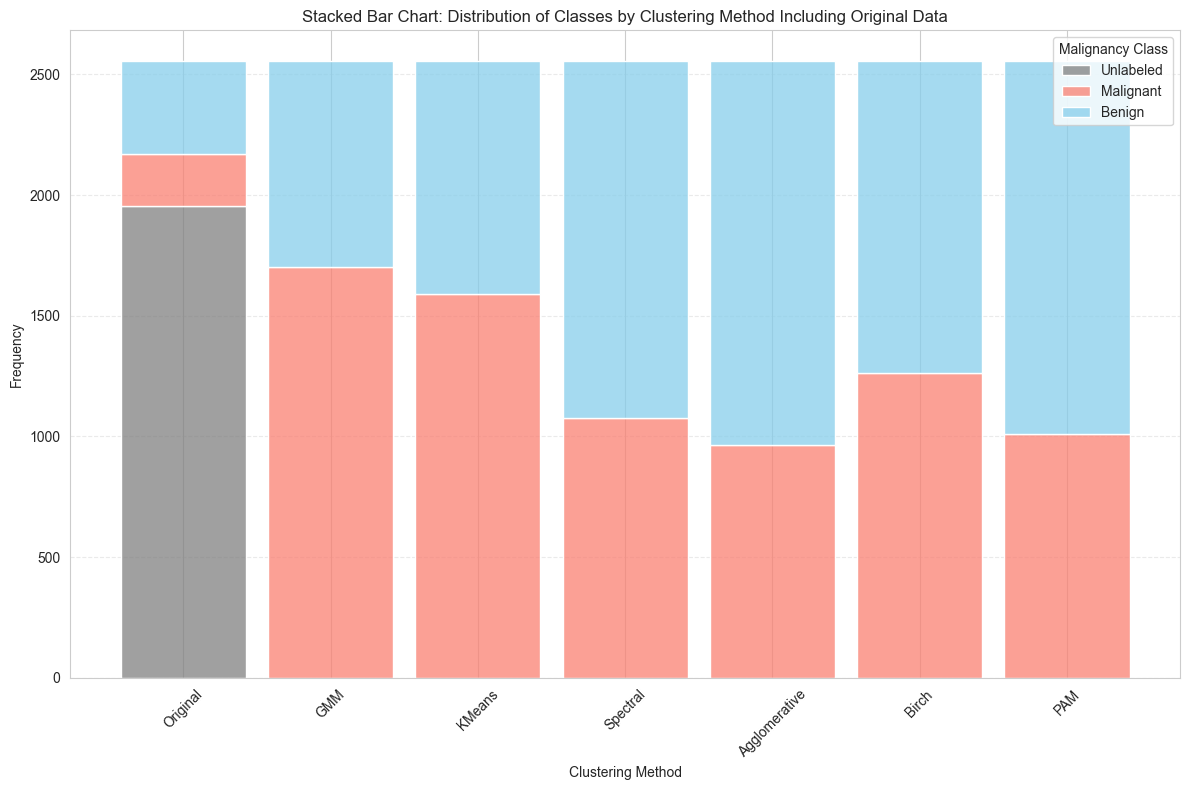

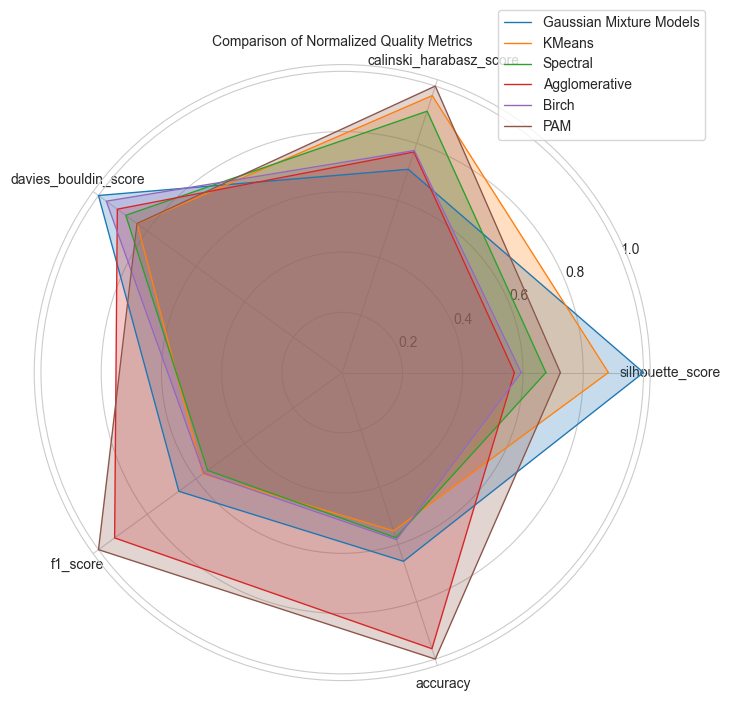

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from Models import apply_clustering

import os

methods = ['GMM', 'KMeans', 'Spectral', 'Agglomerative', 'Birch','PAM']
index = ['Gaussian Mixture Models', 'KMeans', 'Spectral', 'Agglomerative', 'Birch','PAM']
metrics_clustering = pd.DataFrame(columns=['silhouette_score', 'calinski_harabasz_score', 'davies_bouldin_score', 'f1_score','accuracy'], index=index)

df = pd.read_csv('files/final.csv', sep=',', header=0, decimal='.', na_values='?')
df = df.drop(['Unnamed: 0', 'Patient', 'Nodule'], axis=1)
df.rename(columns={'Malignancy_al': 'Malignancy'}, inplace=True)
df['Malignancy'] = df['Malignancy'].replace({'Benigno': 0, 'Unlabeled': 3, 'Maligno': 1})

# Store metrics and cluster results
cluster_results = []
frequency_tables=[]

# Apply each clustering method and store metrics
for method, method_name in zip(methods, index):
    df_updated, si, ch, db, _,f1,acc = apply_clustering(df.copy(), method=method, num_clusters=2, initial_weights=[0.25, 0.75] if method == 'GMM' else None)
    metrics_clustering.loc[method_name] = [si, ch, db, f1,acc]
    cluster_results.append((df_updated.drop(columns=['Malignancy']), df_updated['Malignancy']))

# Combined stacked bar chart of distributions after clustering for all methods
methods.append('Original')
df['Method'] = 'Original'
df_combined = pd.concat([df] + [df.assign(Method=method_name) for df, method_name in zip([res[0].assign(Malignancy=res[1]) for res in cluster_results], methods[:-1])])

plt.figure(figsize=(12, 8))
sns.histplot(data=df_combined, x='Method', hue='Malignancy', multiple='stack', palette=['skyblue', 'salmon', 'gray'], shrink=0.85)
plt.title('Stacked Bar Chart: Distribution of Classes by Clustering Method Including Original Data')
plt.xlabel('Clustering Method')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(title='Malignancy Class', labels=['Unlabeled', 'Malignant','Benign' ])
plt.tight_layout()
# plt.savefig(os.path.join(directory, 'stacked_distribution_clas_combined.png'))




# Comparative plot of quality metrics
metrics = metrics_clustering.columns.tolist()
methods = metrics_clustering.index.tolist()
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Calculate maximum and minimum values for each metric
max_values = metrics_clustering.max()
min_values = metrics_clustering.min()

# Normalize metrics and plot for each method
for method in methods:
    values = metrics_clustering.loc[method].tolist()
    normalized_values = [(val / max_values[i]) if max_values[i] != min_values[i] else 1 for i, val in enumerate(values)]
    normalized_values += normalized_values[:1]
    ax.plot(angles, normalized_values, linewidth=1, linestyle='solid', label=method)
    ax.fill(angles, normalized_values, alpha=0.25)

ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
plt.title('Comparison of Normalized Quality Metrics', size=10)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

The results indicate that only a few models, specifically K-Means, PAM, and Agglomerative Clustering, surpassed the baseline accuracy of 50%. Models based on **density assumptions struggled to perform** effectively on this dataset. In contrast, both K-Means and Agglomerative Clustering maintained distributions that closely matched the proportions of the original dataset, even when excluding unlabeled data. Despite their overall modest performance, these models outperformed random choice, with Agglomerative Clustering showing particularly poor results.

Overall, the findings suggest that **K-Means and PAM** may yield promising results in future applications, warranting their incorporation into our models.

## **Evaluating the model**

Following the clustering phase of our model, we will train a selection of previously tested models and evaluate all semi-supervised clustering approaches in combination with machine learning models using our test dataset. This process will enable a thorough assessment of the models' ability to generalize, which is essential for determining their overall effectiveness. To evaluate model performance, we will employ the following metrics:

### **Context**  

- **TP**: True Positives, positive samples correctly classified .
- **TN**: True Negatives, negatives samples classified as negatives.
- **FP**: False Positives, negative samples incorrrectly classified as positives.
- **FN**: False Negatives, positive samples incorrectly classified as negatives.

### **ROC** 

The **ROC curve** is an analytical method  graphically represented, that is employed for the evaluation of the performance of a binary classifier model when the threshold values are varied. The ROC curve represents  the tradeoff between **True Positive Rate (TPR)** and  **False Positive Rate (FPR)** relate. The ROC curve helps us analysing the capacity of the model to discriminate between two classes,in this case, benign and malignant lung nodules.

* X-axis: Represents the False Positive Rate (FPR).
* Y-axis: Represents the True Positive Rate (TPR).

An effective classifier  will represent a curve which is close to the top left corner, indicating a high true positive rate (TPR) and a low false positive rate (FPR).


### True Positive Rate (TPR)

The **True Positive Rate (TPR)**, known as **Sensitivity** or **Recall**, is a meaured which captures the proportion of actual positives which are correctly classified as positives.

The formula for **TPR** is:

$$
TPR = \frac{TP}{TP + FN}
$$

### False Positive Rate (FPR)

The **False Positive Rate (FPR)** also known as **Precision** is the proportion of actual negatives that are incorrectly classified as positives by the model. 

The formula for **FPR** is:

$$
FPR = \frac{FP}{FP + TN}
$$

### Area Under the ROC Curve (AUC)

The **Area Under the Curve (AUC)** measures the entire two-dimensional area underneath the ROC curve. It provides a single scalar value to evaluate the model’s performance. The value of **AUC** is between 0 and 1, where:

- **AUC = 1**: Perfect classifier.
- **AUC = 0.5**: Random guessing.
- **AUC < 0.5**: Worse than random guessing.

The **AUC** helps to summarize the performance of a model across all classification thresholds.

### ROC-AUC Interpretation

- **High AUC**: This indicates that the model is good at distinguishing between the positive and negative classes. A value close to 1 means the model can classify most of the positive samples correctly while keeping the false positives low.
- **Low AUC**: An AUC closer to 0.5 indicates that the model is not good at distinguishing between the classes, and its performance is close to random guessing.

### Accuracy


 It is the ratio between correctly predicted instances and the total number of instances. In order words, is the percentage of correctly classified instances.

The formula for **Accuracy** is:

$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

### F1-Score 
The **F1-Score** is the harmonic mean between **Precision** and **Recall** ,which provides a single metric that balances both of them. It is especially useful when the class distribution is imbalanced. The F1-Score helps capturing the trade-off between indetifying all relevant instances (Recall) and only labelling relevant instances as positives (Precision). 

The formula for **F1-Score** is:

$$
F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}
$$


C:\Users\Alejandro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Alejandro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/

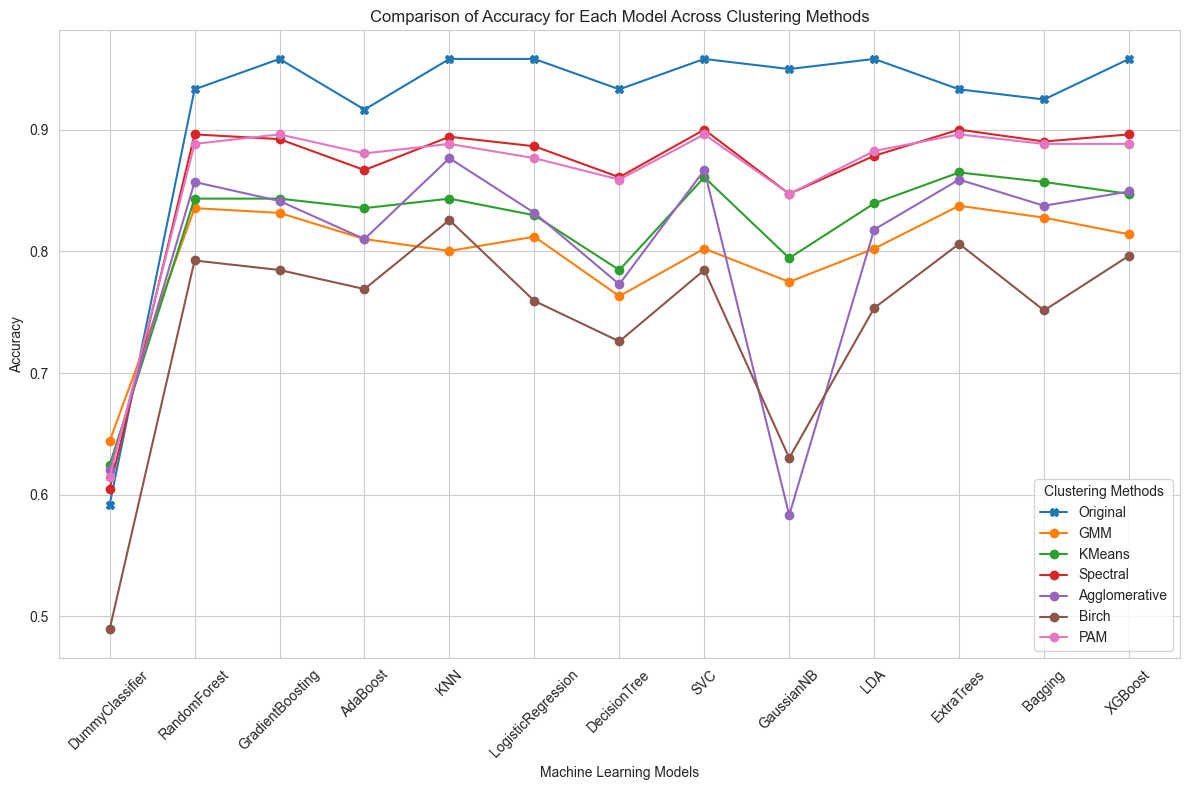

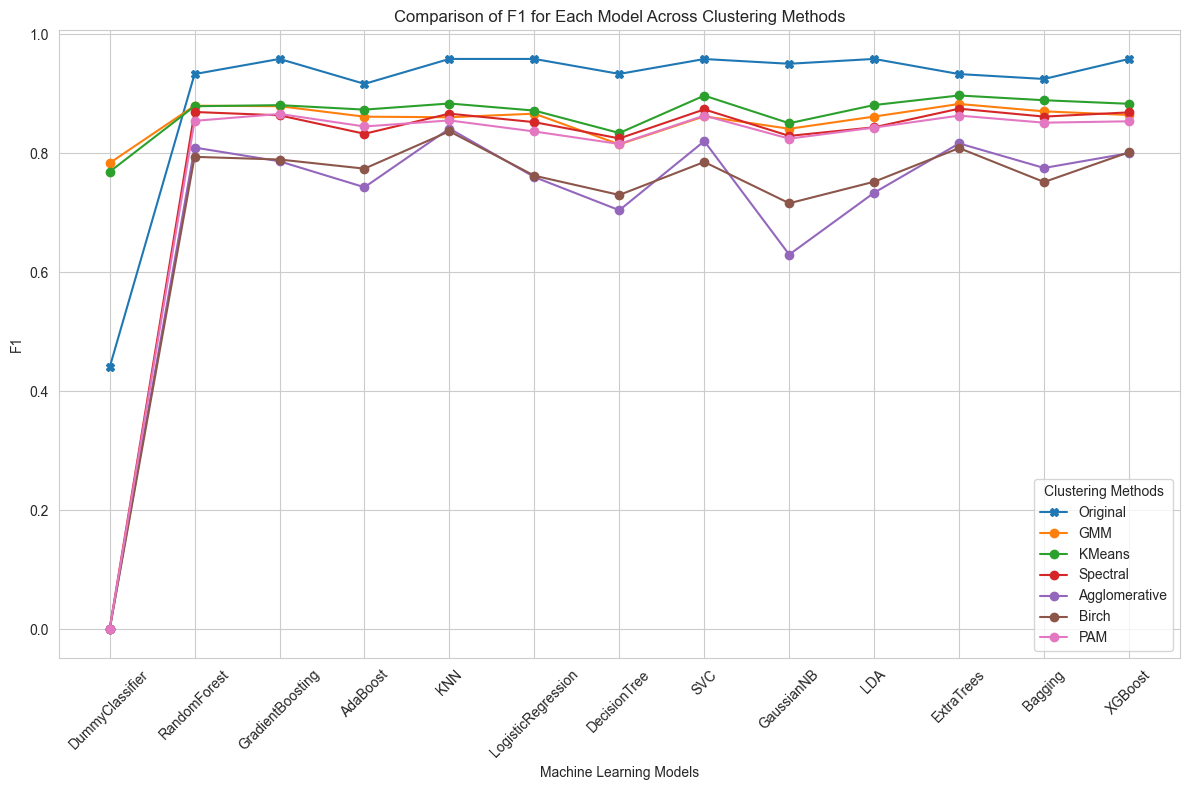

In [16]:
from utils import treat_final_df,create_train_test_split

from sklearn.metrics import accuracy_score,f1_score
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import pandas as pd
import seaborn as sns


methods = ['GMM', 'KMeans', 'Spectral', 'Agglomerative', 'Birch','PAM']
metrics = ['Accuracy', 'F1']

# Define models
models = {
    'DummyClassifier': DummyClassifier(),
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'KNN': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(),
    'DecisionTree': DecisionTreeClassifier(),
    'SVC': SVC(),
    'GaussianNB': GaussianNB(),
    'LDA': LinearDiscriminantAnalysis(),
    'ExtraTrees': ExtraTreesClassifier(),
    'Bagging': BaggingClassifier()
    ,'XGBoost':XGBClassifier()
}


# DataFrames to store results for all clustering methods
all_metrics_df = {metric: pd.DataFrame(columns=models.keys()) for metric in metrics}



# Iterate over clustering methods and datasets
for method, (X, y) in zip(methods, cluster_results):
    X_train_scaled, X_test_scaled, y_train, y_test = create_train_test_split(pd.concat([X, y], axis=1), target_column='Malignancy')

    # DataFrame to store metric results
    metrics_df = pd.DataFrame(columns=metrics, index=models.keys())

    # Train and evaluate each model
    for name, model in models.items():
        #print(f"Training and evaluating {name} for {method} clustering...")
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Store the results in the DataFrame
        metrics_df.loc[name] = [accuracy, f1]

    # Append results to the overall DataFrame
    for metric in metrics:
        all_metrics_df[metric][method] = metrics_df[metric]

# Plot the combined results for Accuracy and F1 Score
for metric in metrics:
    plt.figure(figsize=(12, 8))
    plt.plot(all_metrics_df_original[metric].index, all_metrics_df_original[metric]['Original'], marker='X', label='Original')
    for method in methods:
        plt.plot(all_metrics_df[metric].index, all_metrics_df[metric][method], marker='o', label=method)
    plt.xlabel('Machine Learning Models')
    plt.ylabel(metric)
    plt.title(f'Comparison of {metric} for Each Model Across Clustering Methods')
    plt.xticks(rotation=45)
    plt.legend(title='Clustering Methods')
    plt.tight_layout()
    # plt.savefig(os.path.join(directory, f'combined_{metric}_comparison_models.png'))
    # plt.close()


## **Results**


C:\Users\Alejandro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\xgboost\core.py:158: UserWarning: [16:45:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Alejandro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\xgboost\core.py:158: UserWarning: [16:47:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


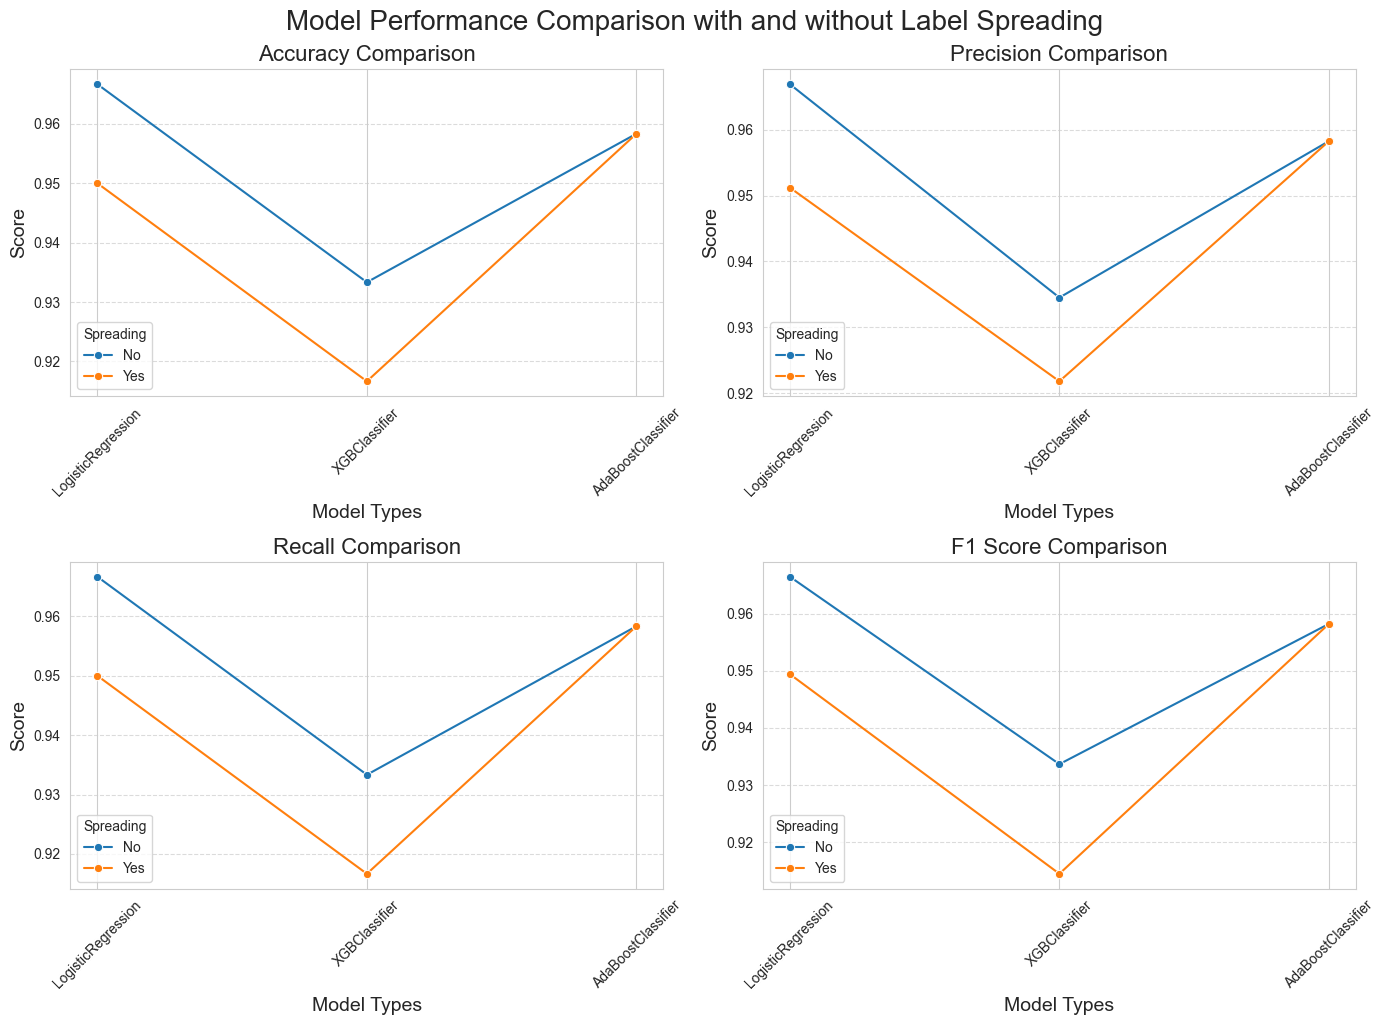

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Asumimos que ya tenemos los conjuntos de datos X_train_scaled, y_train, X_val_scaled, y_val,
# además de las etiquetas predichas por Label Spreading
# Filtramos los datos no ambiguos (Malignancy != "Unlabeled")
X_labeled = data[data["Malignancy_al"] != "Unlabeled"].drop(columns=["Malignancy_al", "Patient", "Nodule"])
y_labeled = data[data["Malignancy_al"] != "Unlabeled"]["Malignancy_al"]

# Define label mapping based on unique values in y_labeled
label_mapping = {
    "Benigno": 0,
    "Maligno": 1,
    "Unlabeled": -1  # If you want to treat "Unlabeled" specifically
}

# Map labels to integers
y_labeled = y_labeled.map(label_mapping)

# Filtramos los datos ambiguos (Malignancy == "Unlabeled")
X_ambiguous = data[data["Malignancy_al"] == "Unlabeled"].drop(columns=["Malignancy_al", "Patient", "Nodule"])
y_ambiguous = data[data["Malignancy_al"] == "Unlabeled"]["Malignancy_al"]


# Split labeled data into training and hold-out (validation) sets
X_train, X_val, y_train, y_val = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42, stratify=y_labeled)

# Normalize features
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_ambiguous_scaled = scaler.transform(X_ambiguous)



y_pred_ambiguous_spread = label_spread_model.transduction_[-len(y_ambiguous):]

# Etiquetas predichas por Label Spreading
y_combined_spread = np.hstack([y_train, y_pred_ambiguous_spread])
X_combined_spread = np.vstack([X_train_scaled, X_ambiguous_scaled])




# Definimos una función para evaluar los modelos
def evaluate_model_with_grid_search(model, param_grid, X_train, y_train, X_val, y_val):
    grid_search = GridSearchCV(model, param_grid, scoring='recall_weighted', cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_val_pred = best_model.predict(X_val)

    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
    recall = recall_score(y_val, y_val_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_val, y_val_pred, average='weighted', zero_division=0)

    return {
        'Model': best_model.__class__.__name__,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Best Params': grid_search.best_params_
    }

# Hiperparámetros de los modelos
log_reg_params = {
    'C': [0.1, 1.0, 10.0],
    'class_weight': ['balanced', None]
}

xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'scale_pos_weight': [1, 5, 10],  # Priorizar la clase positiva
    'use_label_encoder': [False],
    'eval_metric': ['logloss'],
    'random_state': [42]
}

ada_params = {
    'n_estimators': [50, 100],
    'learning_rate': [1.0, 1.5],
    'algorithm': ['SAMME.R', 'SAMME'],  # Puede ayudar a mejorar la performance
    'random_state': [42]
}

# Evaluación de los modelos sin Label Spreading
results_no_spread = []

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
results_no_spread.append(evaluate_model_with_grid_search(log_reg, log_reg_params, X_train_scaled, y_train, X_val_scaled, y_val))

# XGBoost
xgb = XGBClassifier()
results_no_spread.append(evaluate_model_with_grid_search(xgb, xgb_params, X_train_scaled, y_train, X_val_scaled, y_val))

# AdaBoost
ada = AdaBoostClassifier()
results_no_spread.append(evaluate_model_with_grid_search(ada, ada_params, X_train_scaled, y_train, X_val_scaled, y_val))

# Crear DataFrame para los resultados sin Label Spreading
results_no_spread_df = pd.DataFrame(results_no_spread)

# Evaluación de los modelos con Label Spreading
results_with_spread = []

# Logistic Regression con Label Spreading
log_reg_spread = LogisticRegression(max_iter=1000, random_state=42)
results_with_spread.append(evaluate_model_with_grid_search(log_reg_spread, log_reg_params, X_combined_spread, y_combined_spread, X_val_scaled, y_val))

# XGBoost con Label Spreading
xgb_spread = XGBClassifier()
results_with_spread.append(evaluate_model_with_grid_search(xgb_spread, xgb_params, X_combined_spread, y_combined_spread, X_val_scaled, y_val))

# AdaBoost con Label Spreading
ada_spread = AdaBoostClassifier()
results_with_spread.append(evaluate_model_with_grid_search(ada_spread, ada_params, X_combined_spread, y_combined_spread, X_val_scaled, y_val))

# Crear DataFrame para los resultados con Label Spreading
results_with_spread_df = pd.DataFrame(results_with_spread)

# Combine results from models with and without label spreading for visualization
results_combined = pd.concat([
    results_no_spread_df.assign(Spreading='No'), 
    results_with_spread_df.assign(Spreading='Yes')
])

# Set the aesthetics for the plot
sns.set_style("whitegrid")

# Define metrics to plot
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
num_metrics = len(metrics)

# Create a figure with subplots for each metric
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Generate a line plot for each metric in a separate subplot
for i, metric in enumerate(metrics):
    sns.lineplot(data=results_combined, 
                  x='Model', 
                  y=metric, 
                  hue='Spreading', 
                  marker='o', 
                  errorbar=None, 
                  ax=axes[i])  # Specify the current subplot axis

    # Set titles and labels for each subplot
    axes[i].set_title(f'{metric} Comparison', fontsize=16)
    axes[i].set_xlabel('Model Types', fontsize=14)
    axes[i].set_ylabel('Score', fontsize=14)
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-ticks for better visibility
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Set a main title for the entire figure
plt.suptitle('Model Performance Comparison with and without Label Spreading', fontsize=20, y=1.02)

# Display the plots
plt.show()


After comparing all algorithms, both unsupervised and semi-supervised, and their performance in terms of generalization to new data, we have observed that **none seem to outperform the original dataset** resulting from the aforementioned radiologists' consensus algorithm. Although no improvements were found, it is important to highlight the **generalization capacity of label spreading** and the added robustness to the models by incorporating over 1,900 examples into the dataset, achieving an accuracy above 90% and +80% recall, and F1 score  in the hold-out of the original data.

Therefore, we can conclude that **both models**, logistic regression with the original data and the semi-supervised label-spreading data, are robust and effective for the project's objective: predicting cancer in lung nodules showing over 95% of accuracy and recall.

## **Discussion and Future Work**

In this project, we have undertaken a comprehensive data science and engineering endeavor aimed at detecting cancerous nodules in biomedical images of the lungs. Our approach involved processing of images alongside radiologist annotations to develop accurate and robust machine learning (ML) models. A key focus of our methodology was the prioritization of metrics such as recall when selecting the most effective models. This choice was driven by the need to minimize the occurrence of false negatives, which is critical given the serious implications for patient care and outcomes.

Looking ahead, future work could include using wavelet transforms for better feature extraction and exploring 3D volumetric metrics for deeper insights into nodule characteristics. We may also consider leveraging advanced deep learning classification models, which could improve accuracy and reliability.

It is essential to recognize that these models should be viewed as tools to assist radiologists and medical professionals rather than definitive sources of truth. The integration of ML models in clinical practice necessitates careful consideration of their role in decision-making processes. Ultimately, these systems are designed to augment the expertise of healthcare providers, facilitating more informed and timely diagnoses.